In [385]:
import numpy as np
import scipy as sc
from scipy import signal
import matplotlib.pyplot as plt
import random
import math
from scipy.optimize import minimize as mini
from scipy.optimize import least_squares as ls
from scipy.optimize import leastsq
import pyOpt
from pyOpt import CONMIN
from pyOpt import Optimization

In [386]:
cont = np.loadtxt('CONTINUUM/NGC3783-continuum-slope-2-5')
data_comp = np.loadtxt('CONTINUUM/NGC3783-data_comp-slope-2-5')
data = np.loadtxt('CONTINUUM/NGC3783-continuum-slope-2-5')
error = np.loadtxt('CONTINUUM/NGC3783-continuum-slope-2-5')

time2 = data[:,0]
flux2 = data[:,1]
sigma2 = error[:,1]

time1 = []
flux1 = []
sigma1 = []
#print sigma2

for i in range(len(time2)):
    if np.isnan(sigma2[i]):
        print 'yes'
    elif np.isnan(flux2[i]):
        print 'yes 2'
    else:
        time1.append(time2[i])
        flux1.append(flux2[i])
        sigma1.append(sigma2[i])

time1 = np.array(time1)
flux1 = np.array(flux1)
sigma1 = np.array(sigma1)

time = np.insert(time1,0,0)
sigma = np.insert(sigma1,0,np.mean(sigma1))
flux = np.insert(flux1,0,np.mean(flux1))

#sigma1 = -2.5*np.log10((flux1 + sigma1)/FLUX_LAMBDA_VEGA_K)
#sigma = -2.5*np.log10((flux + sigma)/FLUX_LAMBDA_VEGA_K)
#flux1 = -2.5*np.log10(flux1/FLUX_LAMBDA_VEGA_K)
#flux = -2.5*np.log10(flux/FLUX_LAMBDA_VEGA_K)

#sigma1 = abs(sigma1 - flux1)
#sigma = abs(sigma - flux)

#print flux1

#print time
#print sigma
#print flux

In [387]:
b = 8.*10**(-2)
tau = 800.
sigma_tot = 1*10**(-16)

param = [b,tau,sigma_tot]

In [388]:
'''x denotes the observed fluxes, and t the observation times, 
sigma is the error variances and p is the probability function'''

def a_i(t2,t1,tau):
    tau = float(tau)
    return np.exp(-(t2-t1)/tau)

def omega_0(tau,sigma_tot):
    return 0.5*tau*sigma_tot**2

def omega_i(omega_0,a_i,omega_before,sigma_before):
    return omega_0*(1-a_i**2) + a_i**2*omega_before*(1 - omega_before/(omega_before + sigma_before**2))

def x_hat_i(a_i,x_hat_before,omega_before,sigma_before,x_star_before):
    return a_i*x_hat_before + ((a_i*omega_before)/((omega_before + sigma_before**2)))*(x_star_before - x_hat_before)

def x_star_i(x_i,b,tau):
    return x_i - b*tau


In [389]:
def parameters(param):
    x_hat = [0]
    omega = [0.5*param[1]*param[2]**2]
    x_star = [-param[0]*param[1]]
    a = []
    for i in range(len(flux1)):
        a.append(a_i(time[i+1],time[i],param[1]))
        x_hat.append(x_hat_i(a[i],x_hat[i],omega[i],sigma[i],x_star[i]))
        omega.append(omega_i(omega_0(param[1],param[2]),a[i],omega[i],sigma[i]))
        x_star.append(x_star_i(flux[i+1],param[0],param[1]))
    x_hat[0] = np.mean(x_hat)
    x_hat[1] = np.mean(x_hat)
    return x_hat,omega,x_star,a


In [390]:
def prob(param):
    x_hat,omega,x_star,a = parameters(param)
    #print x_hat
    #print x_star
    #print omega
    
    probability = 1
    for i in range(len(a)):
        #print omega[i+1],sigma[i+1]**2 #,x_hat[i+1],x_star[i+1],a[i]
        #print (x_hat[i+1] - x_star[i+1])
        part = np.log(1/np.sqrt(2*np.pi*(omega[i+1] + sigma[i+1]**2)))\
        -(1/2.)*(((x_hat[i+1] - x_star[i+1])**2.)/(omega[i+1] + sigma[i+1]**2.))
        #print part,sigma1[i]
        #print ((x_hat[i+1] - x_star[i+1])**2.)/(omega[i+1] + sigma[i+1]**2.)
        #print 1/np.sqrt(2*np.pi*(omega[i+1] + sigma[i+1]**2))
        probability += part
        #print part, probability
    return -probability

In [391]:
def dX(tau,sigma,dt,b,epsilon,X):
    dt = dt
    sigma = sigma
    return (-(1/tau)*X*dt + sigma*np.sqrt(dt)*epsilon + b*dt)

In [392]:
def flux_model(param):
    res = mini(prob,param,method='Nelder-Mead',tol=1e-18)
    tau = res.x[1] #1400. #res.x[1] #1400. #res.x[1]
    b = res.x[0] #9.2/tau #res.x[0] #7.5*10**(-15)/tau #res.x[0]
    sigma_tot = res.x[2] #0.01 #res.x[2] #1.3*10**(-16) #res.x[2] 
    model = np.zeros((2000,len(flux1)))
    flux_test = flux1[0]
    for j in range(len(model[:,0])):
        model[j,0] = flux1[0]
        #flux_model = [flux1[0]]
        #print j
        for i in range(len(flux1)-1):
            #print i, model[j,i]
            dt = (time1[i+1]-time1[i])
            epsilon = np.random.normal(0,1,1)
            dX1 = (flux1[i+1])#*(-1) + model[j,0]
            change = dX(tau,sigma_tot,dt,b,epsilon,dX1) #flux1[i+1] - flux1[i]
            #print change,flux1[i+1]
            model[j,i+1] = change + flux1[i] #model[j,i] # - flux_test)
    model2 = []
    time_model = []
    std = []
    for i in range(len(model[0,:])):
        model2.append(np.mean(model[:,i]))
        std.append(np.std(model[:,i]))
        time_model.append(time1[i])
    flux_model = np.array((time_model,model2,std,res.x))
    return flux_model,time_model, model2

#model, time_model, model2 = flux_model(param)

def flux_model1(param):
    res = mini(prob,param,method='Nelder-Mead',tol=1e-18)
    tau = res.x[1] #1400. #res.x[1] #1400. #res.x[1]
    b = res.x[0] #9.2/tau #res.x[0] #7.5*10**(-15)/tau #res.x[0]
    sigma_tot = res.x[2] #0.01 #res.x[2] #1.3*10**(-16) #res.x[2] 
    model = np.zeros((2000,len(flux1)))
    flux_test = flux1[0]
    dx_day = np.zeros((2000,len(flux1)))
    timef = time1[::-1]
    fluxf = flux1[::-1]
    #print timef, time1
    for j in range(len(model[:,0])):
        model[j,0] = fluxf[0]
        for i in range(len(fluxf)-1):
            dt = abs(timef[i+1]-timef[i])
            epsilon = np.random.normal(0,1,1)
            dX1 = (fluxf[i+1])#*(-1) + model[j,0]
            change = dX(tau,sigma_tot,dt,b,epsilon,dX1) #flux1[i+1] - flux1[i]
            model[j,i+1] = change + fluxf[i] #model[j,i] # - flux_test)
            dx_day[j,i+1] = change/dt
            #print 2
    model2 = []
    time_model = []
    std = []
    dx_days = []
    for i in range(len(model[0,:])):
        model2.append(np.mean(model[:,i]))
        std.append(np.std(model[:,i]))
        time_model.append(timef[i])
        dx_days.append(np.mean(dx_day[:,i]))
        #print 2
    flux_model = np.array((time_model,model2,std,res.x))
    return flux_model,time_model[::-1], model2[::-1], dx_days[::-1]

In [393]:
model, time_model, model2 = flux_model(param) #p1.join()
model1, time_model1, model12, dx_days1 = flux_model1(param) #p2.join()
#model = np.add(model,model1)/2.
time_model = np.add(time_model,time_model1)/2.
model2 = np.add(model2,model12)/2.

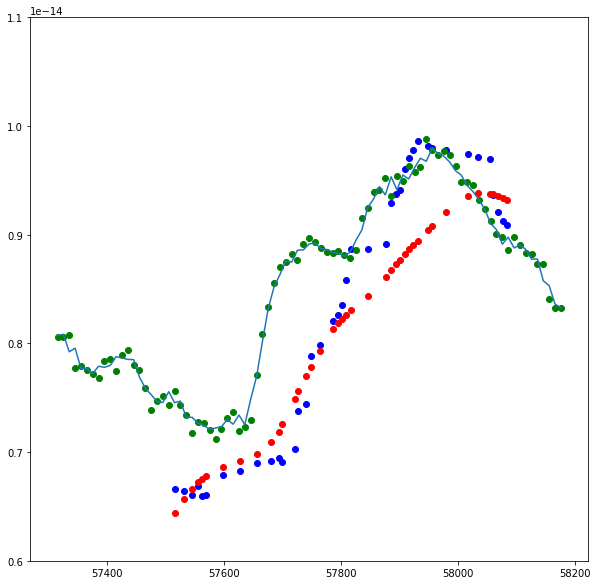

In [394]:
plt.figure(figsize=(10,10))
plt.scatter(data_comp[:,0],data_comp[:,1],color='b')
plt.scatter(data_comp[:,0],data_comp[:,2],color='r')
plt.scatter(cont[:,0],cont[:,1],color='g')
plt.plot(time_model,model2)
plt.ylim([6e-15,1.1e-14])
plt.show(block=False)
plt.figure()

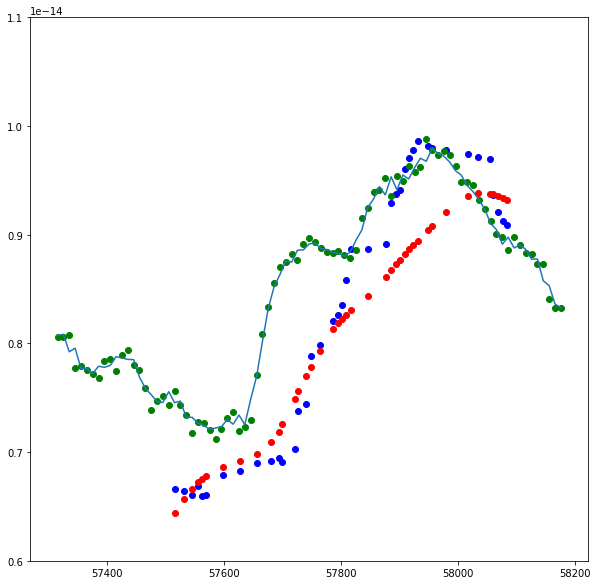

In [395]:
plt.figure(figsize=(10,10))
plt.scatter(data_comp[:,0],data_comp[:,1],color='b')
plt.scatter(data_comp[:,0],data_comp[:,2],color='r')
plt.scatter(cont[:,0],cont[:,1],color='g')
plt.plot(time_model,model2)
plt.ylim([6e-15,1.1e-14])
plt.show(block=False)
plt.figure()
#plt.scatter(freq,P_show,color='b')
#plt.ylim([1e-21,1e-31])
#plt.xlim([1e-8,3e-7])
#plt.yscale('log')
#plt.xscale('log')
#plt.show(block=False)

In [396]:
print random.random()
print np.shape(cont[:,1])
print np.shape(cont[:,0])

0.224279862138
(87,)
(87,)


[0.         0.01149425 0.02298851 0.03448276 0.04597701 0.05747126
 0.06896552 0.08045977 0.09195402 0.10344828 0.11494253 0.12643678
 0.13793103 0.14942529 0.16091954 0.17241379 0.18390805 0.1954023
 0.20689655 0.2183908  0.22988506 0.24137931 0.25287356 0.26436782
 0.27586207 0.28735632 0.29885057 0.31034483 0.32183908 0.33333333
 0.34482759 0.35632184 0.36781609 0.37931034 0.3908046  0.40229885
 0.4137931  0.42528736 0.43678161 0.44827586 0.45977011 0.47126437
 0.48275862 0.49425287]
[5.55533457e-31 3.95017454e-29 1.05761810e-29 1.94961350e-30
 2.41040205e-30 9.07431850e-31 5.25726434e-31 1.39449260e-31
 1.28124218e-33 9.10165172e-32 2.50056901e-31 1.10004925e-31
 2.39129827e-32 9.39403491e-33 3.00846976e-32 5.17308129e-32
 1.67901027e-32 2.28465029e-33 2.83113701e-32 2.70830315e-32
 1.28717251e-32 9.93402649e-33 4.31780386e-33 8.09738550e-33
 3.45651392e-33 1.18157239e-32 1.62252267e-33 7.98901829e-34
 1.44020812e-33 4.75781361e-34 6.30188446e-33 2.61123231e-33
 2.04320236e-34 3.72

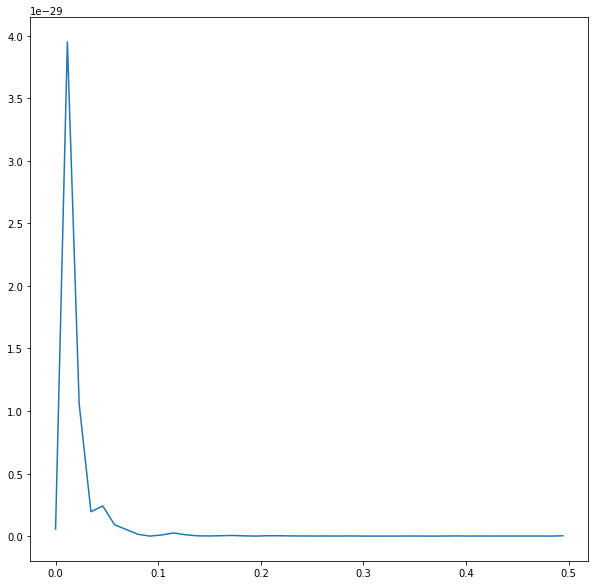

In [397]:
x, den = signal.welch(cont[:,1],scaling='density')

print x
print den

plt.figure(figsize=(10,10))
plt.plot(x,den)
plt.show()